# Fanal, a neutrino-less beta decay experiment 

## An open exercise

### Background uncertainty estimation 


#### USC, Master de Física, Física de Partículas II


J. A. Hernando-Morata

February 2021 - February 2022

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#### Importing modules

In [2]:
import numpy  as np
import tables as tb
import pandas as pd
import matplotlib.pyplot as plt

import scipy.stats     as stats  # statistics and Many PDFs 
#import scipy.optimize  as optimize # Minimice funtions

import warnings
warnings.filterwarnings('ignore')

In [3]:
# REMEMBER TO ADD Your Fanal FOLDER TO PYTHONPATH
import os
import sys
import importlib
dirpath = os.getcwd()[:-9]
print('add path to PYTHONPATH : ', dirpath)
sys.path.insert(0, os.path.abspath(dirpath))

add path to PYTHONPATH :  /Users/hernando/work/docencia/master/Fisica_Particulas/USC-Fanal


In [4]:
import core.pltext  as pltext   # extensions for plotting histograms
import core.hfit    as hfit     # extension to fit histograms
import core.efit    as efit     # Fit Utilites - Includes Extend Likelihood Fit with composite PDFs
import core.utils   as ut       # generic utilities
import ana.fanal    as fn       # analysis functions specific to fanal
import ana.pltfanal as pltfn    # plotting fanal functions
import     collpars as collpars # collaboration specific parameters
pltext.style()

## Indications

### Objective

   * **Estimate the uncerntainty on the background contamination**, the number of Bi and Tl events, using blind-data.

### Tasks

   * Do a **likelihood profile scan** to estimate the uncertainties in the number Bi and Tl events

### Exercises:

  * Generate m-large simulation experiments with the estimated number of Bi and Tl events and get the distribution of the number of events of Bi, Tl in RoI.
  
  * Verify that the uncertainty with the MC experiments is equal or similar to the one obtained with the LikeLihood scan.


## Main Parameters

In [5]:
coll          = collpars.collaboration
ntracks_range = collpars.ntracks_range
eblob2_range  = collpars.eblob2_range
erange        = collpars.erange
eroi          = collpars.eroi

print('Collaboration             : {:s}'.format(coll))
print('number of tracks range    : ({:d}, {:6.2f})'.format(*ntracks_range))
print('Blob-2 energy range       : ({:6.3f}, {:6.3f}) MeV'.format(*eblob2_range))
print('Energy range              : ({:6.3f}, {:6.3f}) MeV'.format(*erange))
print('Energy RoI range          : ({:6.3f}, {:6.3f}) MeV'.format(*eroi))

Collaboration             : new_beta
number of tracks range    : (1,   1.10)
Blob-2 energy range       : ( 0.400,  1.200) MeV
Energy range              : ( 2.400,  2.700) MeV
Energy RoI range          : ( 2.430,  2.480) MeV


In [6]:
# number of  blind events
nevts_Bi_blind = collpars.nevts_Bi_blind
nevts_Tl_blind = collpars.nevts_Tl_blind
nevts_blind    = [nevts_Bi_blind, nevts_Tl_blind]
print('Number of bkg events in blind data : Bi = {:6.2f}, Tl = {:6.2f}.'.format(*nevts_blind))

Number of bkg events in blind data : Bi = 1102.09, Tl = 14625.49.


## Access the data

In [7]:
#dirpath = '/Users/hernando/docencia/master/Fisica_Particulas/USC-Fanal/data/'
filename = '/data/fanal_' + coll + '.h5'
print('Data path and filename : ', dirpath + filename)

mcbi       = pd.read_hdf(dirpath + filename, key = 'mc/bi214')   # MC Bi
mctl       = pd.read_hdf(dirpath + filename, key = 'mc/tl208')   # MC Tl
data_blind = pd.read_hdf(dirpath + filename, key = 'data/blind') # blind data

mcs      = [mcbi, mctl]
tsamples = ['Bi', 'Tl']
ssamples = [r'$^{214}$Bi', r'$^{208}$Tl']

Data path and filename :  /Users/hernando/work/docencia/master/Fisica_Particulas/USC-Fanal/data/fanal_new_beta.h5


### Re-do the fit


Initial   number of events : 1102.09,  14625.49, 
Estimated number of events : 1101.70,  14625.40, 


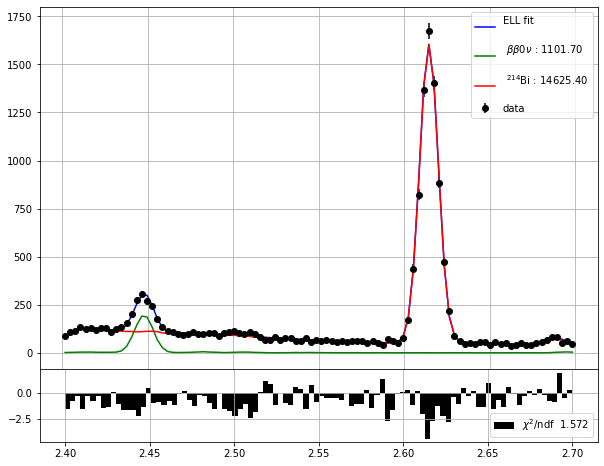

In [8]:
# get the blind mc samples
mcs_blind  = [mc[fn.selection_blind(mc)] for mc in mcs]

nevts_blind = (collpars.nevts_Bi_blind, collpars.nevts_Tl_blind)

varname   = 'E'
refnames  = (varname,) 
refranges = (erange,)

fit        = fn.prepare_fit_ell(mcs_blind, nevts_blind, refnames, refranges)

result, enes, ell, _ = fit(data_blind)
nevts_est = result.x

print('Initial   number of events :', *['{:6.2f}, '.format(ni) for ni in nevts_blind])
print('Estimated number of events :', *['{:6.2f}, '.format(ni) for ni in nevts_est])
# it also plots the histogram, the fit function, and the pdfs samples
pltfn.plot_fit_ell(enes, nevts_est, ell)

## Do a Profile Likelihood Scan

We compute the uncertainties usign the log Likelihood scan

The uncertainties on $\mu$, in the gaussian domain, when there are two parameters $\mu, \nu$, are defined as the $\mu$ values where:

$$
t_\mu(x) = 
-2 \, \mathrm{log} \frac{\mathcal{L}(x | \mu, \hat{\nu}(\mu))}{\mathcal{L}(x | \hat{\mu}, \hat{\nu})} = \Delta - 2 \mathrm{log} \mathcal{L} = 1
$$


  * Do a likelihood profile scan

  * Compute the 68% CI region

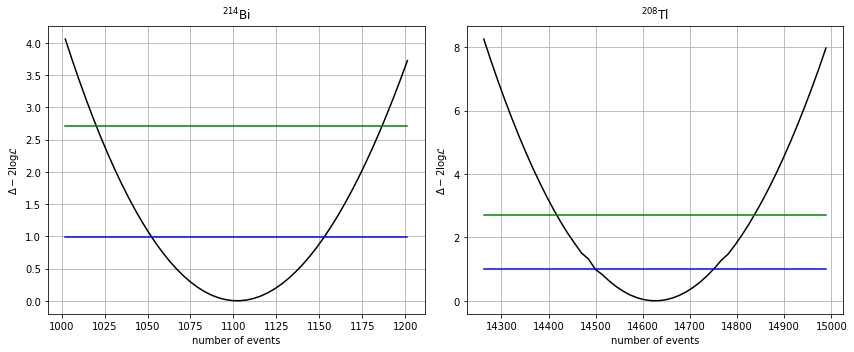

In [9]:
nis, tmus = fn.tmu_scan(enes, nevts_est, ell, sizes = (3., 3.))
pltfn.plot_tmu_scan(nis, tmus, titles = ssamples)

In [10]:
cl    = 0.68
mucis = [efit.tmu_conf_int(ni, tmu, cl) for ni, tmu in zip(nis, tmus)]
for i, ci in enumerate(mucis):
    print('Number of {:s} events CI at {:4.0f} % CL = ({:5.2f}, {:5.2f})'.format(tsamples[i], 100*cl, *ci))

Number of Bi events CI at   68 % CL = (1054.96, 1152.50)
Number of Tl events CI at   68 % CL = (14499.53, 14736.47)


In [11]:
for i, ci in enumerate(mucis):
    print('Number of {:s} events CI at {:4.0f} % CL = {:5.2f}  {:5.2f} +{:5.2f}'.format(tsamples[i], 100*cl, 
                                                                                        result.x[i],
                                                                                        *(ci - result.x[i])))

Number of Bi events CI at   68 % CL = 1101.70  -46.74 +50.80
Number of Tl events CI at   68 % CL = 14625.40  -125.87 +111.06


## Computing the uncertainties in the number of Bkg

 * Compute the uncertainties in the total number of background events.
 
 * Compute the uncertainties in the number of background events in the RoI, *eroi*, and Energy, *erange*, regions.


In [12]:
unevts_blind = np.array([np.max(ci) - np.mean(ci) for ci in mucis])
effs_blind   = np.array((collpars.eff_Bi_blind, collpars.eff_Tl_blind))
unevts       = unevts_blind/effs_blind

for i, u in enumerate(unevts_blind):
    print('Uncertainty in number of Blind {:s} events  = {:6.3f} '.format(tsamples[i], u))
for i, u in enumerate(unevts):
    print('Uncertainty in number          {:s} events  = {:6.3f} '.format(tsamples[i], u))

Uncertainty in number of Blind Bi events  = 48.772 
Uncertainty in number of Blind Tl events  = 118.467 
Uncertainty in number          Bi events  = 62.129 
Uncertainty in number          Tl events  = 167.564 


In [13]:
effs_E     = np.array((collpars.eff_Bi_E  , collpars.eff_Tl_E))
effs_roi   = np.array((collpars.eff_Bi_RoI, collpars.eff_Tl_RoI))

unevts_E   = unevts * effs_E
unevts_roi = unevts * effs_roi

for i, u in enumerate(unevts_E):
    print('Uncertainty in number of {:s} events in erange = {:6.3f} '.format(tsamples[i], u))
for i, u in enumerate(unevts_roi):
    print('Uncertainty in number of {:s} events in RoI    = {:6.3f} '.format(tsamples[i], u))

Uncertainty in number of Bi events in erange =  1.118 
Uncertainty in number of Tl events in erange =  1.223 
Uncertainty in number of Bi events in RoI    =  0.963 
Uncertainty in number of Tl events in RoI    =  0.033 


## Write Out

In [14]:
write = True

if (write):
    of = open('collpars.py', 'a')
    for i, sample in enumerate(tsamples):
        of.write('unevts_'+sample+'       = {:6.3f}'.format(unevts[i])+'\n')
        of.write('unevts_'+sample+'_blind = {:6.3f}'.format(unevts_blind[i])+'\n')
        of.write('unevts_'+sample+'_E     = {:6.3f}'.format(unevts_E[i])  +'\n')
        of.write('unevts_'+sample+'_RoI   = {:6.3f}'.format(unevts_roi[i])  +'\n')
    of.close()